In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import numpy.ma as ma
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io.xarray import CfRadial, OdimH5


import urllib
import os
from osgeo import osr
import io
import glob
import datetime as dt

import matplotlib.patheffects as pe
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from metpy.plots import ctables
from pyproj import Proj
import ftplib

In [2]:
ftp = ftplib.FTP('ftprod-me.oma.be', 'meteolux', 'Jukebox-Next-Grandkid')

#List the files in the current directory
print("Latest File:")
files = ftp.nlst("*PAGZ41*")
files.sort()
f=files[-1]
print(f)
with open(files[-1], "wb" ) as file :
        ftp.retrbinary('RETR '+ f, file.write)
        file.close()
ftp.quit()

Latest File:
T_PAGZ41_C_EBUM_20210910232959.hdf


'221 Goodbye.'

In [3]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import metpy
import requests
import matplotlib.pyplot as pl
import matplotlib.patheffects as pe
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from metpy.plots import ctables
from osgeo import osr
from wradlib.io.xarray import CfRadial, OdimH5

import urllib
import io
import glob
import datetime
from datetime import timedelta

try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
    
flist = glob.glob('/home/lmathias/Documents/wradlib/wid/pcappi/T_PAGZ41_*')
flist.sort()
f=flist[-1]
print(f)

vol = wrl.io.OdimH5(f, standard='cf', georef=True)

list(vol)
time = vol.root.time_coverage_end

print(time.item())

time = time.item()

import dateutil.parser
time = dateutil.parser.parse(time)
time2 = time.strftime("%Y%m%d%H%M")


time2 = datetime.datetime.utcfromtimestamp(vol['sweep_1'].time.item(180)/1000000000)
print(time2)

time3 = datetime.datetime.utcfromtimestamp(vol['sweep_2'].time.item(180)/1000000000)
print(time3)

time4 = datetime.datetime.utcfromtimestamp(vol['sweep_3'].time.item(180)/1000000000)
print(time4)

time5 = datetime.datetime.utcfromtimestamp(vol['sweep_4'].time.item(180)/1000000000)
print(time5)

time6 = datetime.datetime.utcfromtimestamp(vol['sweep_5'].time.item(180)/1000000000)
print(time6)

time7 = datetime.datetime.utcfromtimestamp(vol['sweep_6'].time.item(180)/1000000000)
print(time7)

/home/lmathias/Documents/wradlib/wid/pcappi/T_PAGZ41_C_EBUM_20210910232959.hdf
2021-09-10T23:30:01Z
2021-09-10 23:29:47.750003
2021-09-10 23:29:19.972230
2021-09-10 23:28:32.416671
2021-09-10 23:28:04.805565
2021-09-10 23:27:34.750007
2021-09-10 23:26:46.027781


<Figure size 720x576 with 0 Axes>

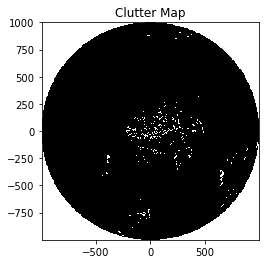

In [4]:
DBZH3 = vol['sweep_1'].DBZH

clutter = wrl.clutter.filter_gabella(DBZH3.data, wsize=5,
                               thrsnorain=0.1,
                                tr1=3.0, n_p=8, tr2=1.3)
pl.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(clutter, cmap=pl.cm.gray)
pl.title('Clutter Map')
data_no_clutter = wrl.ipol.interpolate_polar(DBZH3.data, clutter, ipclass = wrl.ipol.Nearest)

DBZH3.data = data_no_clutter
vol['sweep_1'].DBZH.data = DBZH3.data

vol.to_odim('rmib_odim.h5')

In [5]:
filename = 'rmib_odim.h5'
raw = wrl.io.read_opera_hdf5(filename)
# this is the radar position tuple (longitude, latitude, altitude)
sitecoords = (raw["where"]["lon"], raw["where"]["lat"],
              raw["where"]["height"])
# define your cartesian reference system
# proj = wradlib.georef.create_osr(32632)
proj = osr.SpatialReference()
proj.ImportFromEPSG(32632)
# containers to hold Cartesian bin coordinates and data
xyz, data = np.array([]).reshape((-1, 3)), np.array([])
# iterate over 11 elevation angles
for i in range(10):
    # get the scan metadata for each elevation
    where = raw["dataset%d/where" % (i + 1)]
    what = raw["dataset%d/data1/what" % (i + 1)]
    # define arrays of polar coordinate arrays (azimuth and range)
    az = np.arange(0., 360., 360. / where["nrays"])
    # rstart is given in km, so multiply by 1000.
    rstart = where["rstart"] * 1000.
    r = np.arange(rstart,
                  rstart + where["nbins"] * where["rscale"],
                  where["rscale"])
    # derive 3-D Cartesian coordinate tuples
    xyz_ = wrl.vpr.volcoords_from_polar(sitecoords, where["elangle"],
                                        az, r, proj)
    # get the scan data for this elevation
    #   here, you can do all the processing on the 2-D polar level
    #   e.g. clutter elimination, attenuation correction, ...
    data_ = what["offset"] + what["gain"] * raw[
        "dataset%d/data1/data" % (i + 1)]
    # transfer to containers
    xyz, data = np.vstack((xyz, xyz_)), np.append(data, data_.ravel())

# generate 3-D Cartesian target grid coordinates
maxrange = 220000.
minelev = 0.1
maxelev = 25.
maxalt = 1500.
horiz_res = 250.
vert_res = 250.
trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords, proj, maxrange,
                                        maxalt, horiz_res, vert_res)

# interpolate to Cartesian 3-D volume grid
tstart = dt.datetime.now()
gridder = wrl.vpr.PseudoCAPPI(xyz, trgxyz, trgshape, maxrange, minelev,
                        maxelev, wrl.ipol.Idw)
vol = np.ma.masked_invalid(gridder(data).reshape(trgshape))
print("3-D interpolation took:", dt.datetime.now() - tstart)

cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')

newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

# diagnostic plot
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]


#fig = pl.figure(figsize=(20,13))
#wrl.vis.plot_max_plan_and_vert(trgx, trgy, trgz, vol, unit="dBZ", cmap=newcmap,
                               #levels=range(0, 70))

3-D interpolation took: 0:00:17.009981


CAPPI it's a Constant Altitude Plan Position Indicator. So you need to select a height for your CAPPI.

In [6]:
i=5
print(trgz[i])
print(trgx.shape)
print(trgy.shape)
cappi750 = vol[i,:,:]
print(cappi750.shape)
size = cappi750.shape[1]
print(size)
cappi750= cappi750[0:size,0:size]
#cappi750 = ma.masked_where(cappi750 < 0,cappi750)

1250.0
(1761,)
(1761,)
(1761, 1761)
1761


For plotting with shapefile that is already in WSG84 coordinates, I convert data to this coordinates. 

In [7]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



X, Y = np.meshgrid(trgx[0:size], trgy[0:size])
Z = np.meshgrid(trgz)
zone = wrl.georef.epsg_to_osr(4326)   # EPSG Number (WSG 84)
C = np.zeros((size,size,2)) # Just a dirty way to stack those arrays jejeje 
C[:,:,0] = X
C[:,:,1] = Y

zone_coords = wrl.georef.reproject(C,projection_source=proj, projection_target=zone)  # Reproject
x = zone_coords[..., 0]
y = zone_coords[..., 1]

# Gridding
xgrid = np.linspace(x.min(), x.max(), size-1)  
ygrid = np.linspace(y.min(), y.max(), size-1)
grid_xy = np.meshgrid(xgrid, ygrid)
grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()

xy=np.concatenate([x.ravel()[:,None],y.ravel()[:,None]], axis=1)
gridded = wrl.comp.togrid(src=xy, trg=grid_xy, radius=100., center=np.array([x.mean(), y.mean()]),
                          data=cappi750.ravel(), interpol=wrl.ipol.Idw)
# Masked arrays 
gridded = np.ma.masked_invalid(gridded).reshape((len(xgrid), len(ygrid)))
gridded = ma.masked_where(gridded <= 0, gridded)

rmib_pcappi_202109102329.jpeg


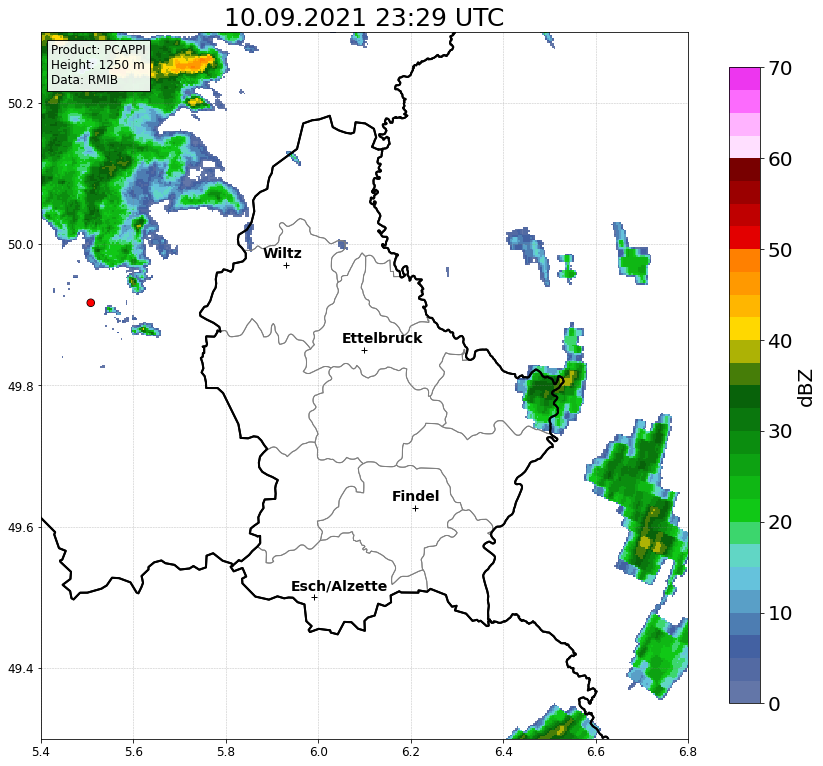

In [8]:
def plot_borders2(ax):
    filename = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_0.shp')
    filename3 = wrl.util.get_wradlib_data_file('geo/gadm36_BEL_0.shp')
    filename4 = wrl.util.get_wradlib_data_file('geo/gadm36_FRA_0.shp')
    filename5 = wrl.util.get_wradlib_data_file('geo/gadm36_DEU_0.shp')
    dataset, inLayer = wrl.io.open_vector(filename)
    dataset3, inLayer3 = wrl.io.open_vector(filename3)
    dataset4, inLayer4 = wrl.io.open_vector(filename4)
    dataset5, inLayer5 = wrl.io.open_vector(filename5)
    borders, keys = wrl.georef.get_vector_coordinates(inLayer)
    borders3, keys3 = wrl.georef.get_vector_coordinates(inLayer3)
    borders4, keys4 = wrl.georef.get_vector_coordinates(inLayer4)
    borders5, keys5 = wrl.georef.get_vector_coordinates(inLayer5)
    wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders3, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders4, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders5, color='black', lw=2, zorder=4)

#def plot_cities(ax):
#    lats = [49.75,49.627,49.5,49.66,49.97,49.545,49.556,49.83]
#    lons = [6.1,6.21,5.99,5.92,5.93,6.367,5.875,5.85]
#    cities = ['Mersch','Findel','Esch/Alzette','Steinfort','Wiltz','Remich','Pétange','Rambrouch']
#    for lon, lat, city in zip(lons, lats, cities):
#        ax.plot(lon, lat, 'k+', zorder=5, transform=ccrs.PlateCarree())
#        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
#                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
#                transform=ccrs.PlateCarree())
        
def plot_cities(ax):
    lats = [49.85,49.627,49.5,49.97]
    lons = [6.1,6.21,5.99,5.93]
    cities = ['Ettelbruck','Findel','Esch/Alzette','Wiltz']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'k+', zorder=5)
        ax.text(lon - 0.05, lat + 0.01, city, fontsize='14', fontweight='bold', 
                 color='black', zorder=5)
        
def plot_cant(ax):
    filename6 = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_2.shp')
    dataset6, inLayer6 = wrl.io.open_vector(filename6)
    borders6, keys6 = wrl.georef.get_vector_coordinates(inLayer6)
    wrl.vis.add_lines(ax, borders6, color='grey', lw=1, zorder=2)
    
def plot_radloc(ax):
    lats = [49.917]
    lons = [5.508]
    cities = ['']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'ro', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])
        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])
        

fig = pl.figure(figsize=(14.5,13))
ax = pl.subplot(111)
pm = ax.pcolormesh(xgrid, ygrid, gridded, cmap=newcmap, vmin=0, vmax=70)
pl.title(time2.strftime("%d.%m.%Y %H:%M UTC"),fontsize=25)
#pl.xlabel("Longitude ",fontsize=20) 
#pl.ylabel("Latitude",fontsize=20)
cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[0,10,20,30,40,50,60,70],orientation='vertical')
cb.set_label("dBZ",fontsize=20)
cb.ax.tick_params(labelsize=20)
pl.xlim(5.4, 6.8)
pl.ylim(49.3, 50.3)
pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
pl.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
plot_cant(ax)
plot_borders2(ax)
plot_radloc(ax)
plot_cities(ax)

t=pl.gcf().text(0.135, 0.825, 'Product: PCAPPI\nHeight: 1250 m\nData: RMIB', fontsize=12)
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))

base_filename='rmib_pcappi_'
suffix='.jpeg'
latest='latest'
#endfile=os.path.join(dir_name,base_filename+rwattrs['datetime'].strftime("%Y%m%d%H%M")+suffix)
#print(endfile)
#fig.savefig('endfile')
my_file = base_filename+time2.strftime("%Y%m%d%H%M")+suffix
#my_file2 = base_filename+latest+suffix
print(my_file)
#print(my_file2)
if os.path.isfile(my_file):
   os.remove(my_file)   # Opt.: os.system("rm "+strFile)
pl.savefig(my_file, bbox_inches='tight')
#pl.savefig(my_file2) 

rmib_pcappi_large_202109102329.jpeg


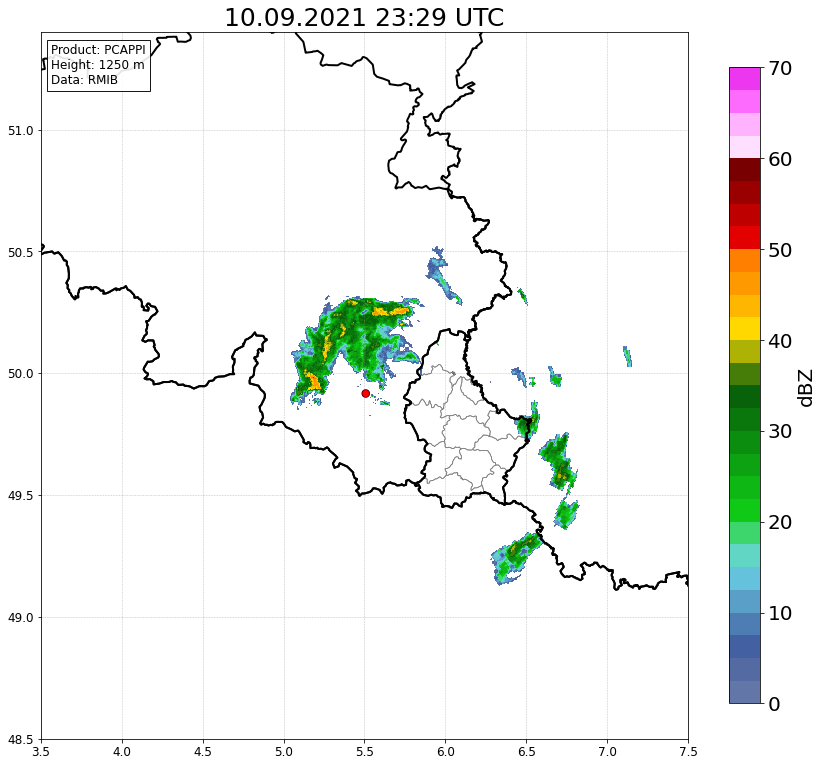

In [9]:
def plot_borders2(ax):
    filename = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_0.shp')
    filename3 = wrl.util.get_wradlib_data_file('geo/gadm36_BEL_0.shp')
    filename4 = wrl.util.get_wradlib_data_file('geo/gadm36_FRA_0.shp')
    filename5 = wrl.util.get_wradlib_data_file('geo/gadm36_DEU_0.shp')
    dataset, inLayer = wrl.io.open_vector(filename)
    dataset3, inLayer3 = wrl.io.open_vector(filename3)
    dataset4, inLayer4 = wrl.io.open_vector(filename4)
    dataset5, inLayer5 = wrl.io.open_vector(filename5)
    borders, keys = wrl.georef.get_vector_coordinates(inLayer)
    borders3, keys3 = wrl.georef.get_vector_coordinates(inLayer3)
    borders4, keys4 = wrl.georef.get_vector_coordinates(inLayer4)
    borders5, keys5 = wrl.georef.get_vector_coordinates(inLayer5)
    wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders3, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders4, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders5, color='black', lw=2, zorder=4)

#def plot_cities(ax):
#    lats = [49.75,49.627,49.5,49.66,49.97,49.545,49.556,49.83]
#    lons = [6.1,6.21,5.99,5.92,5.93,6.367,5.875,5.85]
#    cities = ['Mersch','Findel','Esch/Alzette','Steinfort','Wiltz','Remich','Pétange','Rambrouch']
#    for lon, lat, city in zip(lons, lats, cities):
#        ax.plot(lon, lat, 'k+', zorder=5, transform=ccrs.PlateCarree())
#        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
#                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
#                transform=ccrs.PlateCarree())
        
def plot_cities(ax):
    lats = [49.85,49.627,49.5,49.97]
    lons = [6.1,6.21,5.99,5.93]
    cities = ['Ettelbruck','Findel','Esch/Alzette','Wiltz']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'k+', zorder=5)
        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])
        
def plot_cant(ax):
    filename6 = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_2.shp')
    dataset6, inLayer6 = wrl.io.open_vector(filename6)
    borders6, keys6 = wrl.georef.get_vector_coordinates(inLayer6)
    wrl.vis.add_lines(ax, borders6, color='grey', lw=0.75, zorder=4)
    
def plot_radloc(ax):
    lats = [49.917]
    lons = [5.508]
    cities = ['']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'ro', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])
        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")])
        
cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')

newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

fig = pl.figure(figsize=(14.5,13))
ax = pl.subplot(111)
pm = ax.pcolormesh(xgrid, ygrid, gridded, cmap=newcmap, vmin=0, vmax=70)
pl.title(time2.strftime("%d.%m.%Y %H:%M UTC"),fontsize=25)
#pl.xlabel("Longitude ",fontsize=20) 
#pl.ylabel("Latitude",fontsize=20)
cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[0,10,20,30,40,50,60,70],orientation='vertical')
cb.set_label("dBZ",fontsize=20)
cb.ax.tick_params(labelsize=20)
pl.xlim(3.5, 7.5)
pl.ylim(48.5, 51.4)
pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
pl.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
plot_cant(ax)
plot_borders2(ax)
plot_radloc(ax)
#plot_cities(ax)
t=pl.gcf().text(0.135, 0.825, 'Product: PCAPPI\nHeight: 1250 m\nData: RMIB', fontsize=12)
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))

base_filename='rmib_pcappi_large_'
suffix='.jpeg'
latest='latest'
#endfile=os.path.join(dir_name,base_filename+rwattrs['datetime'].strftime("%Y%m%d%H%M")+suffix)
#print(endfile)
#fig.savefig('endfile')
my_file = base_filename+time2.strftime("%Y%m%d%H%M")+suffix
#my_file2 = base_filename+latest+suffix
print(my_file)
#print(my_file2)
if os.path.isfile(my_file):
   os.remove(my_file)   # Opt.: os.system("rm "+strFile)
pl.savefig(my_file, bbox_inches='tight')
#pl.savefig(my_file2) 

rmib_pcappi_findel_202109102329.jpeg


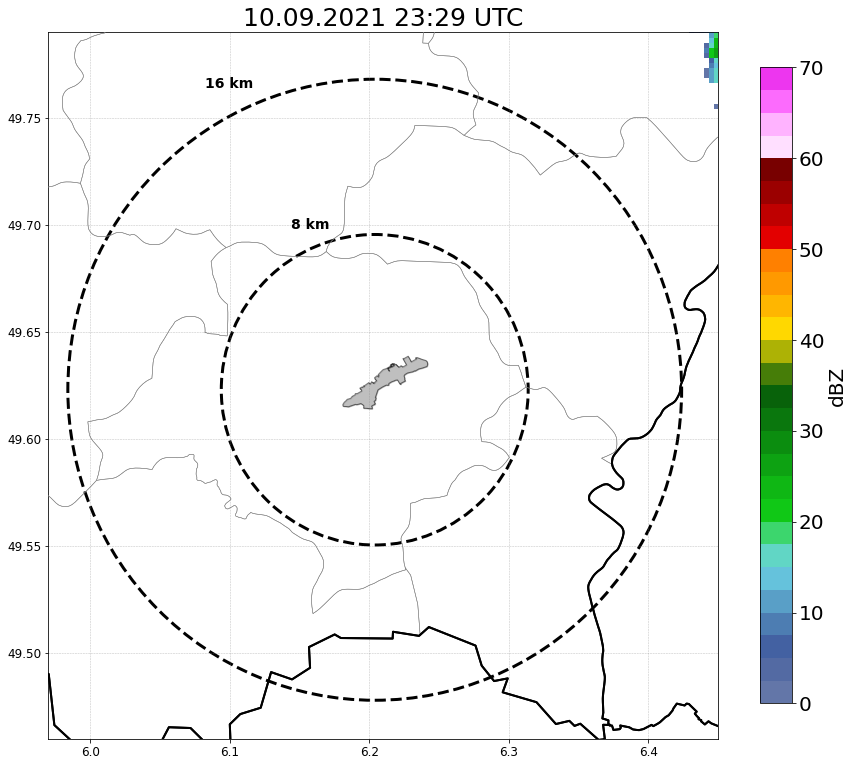

In [10]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeodesic
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import shapely
import matplotlib.patches as mpatches

def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_boundary_lines_land',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=4, zorder=4)
    

def plot_borders2(ax):
    filename = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_0.shp')
    filename3 = wrl.util.get_wradlib_data_file('geo/gadm36_BEL_0.shp')
    filename4 = wrl.util.get_wradlib_data_file('geo/gadm36_FRA_0.shp')
    filename5 = wrl.util.get_wradlib_data_file('geo/gadm36_DEU_0.shp')
    dataset, inLayer = wrl.io.open_vector(filename)
    dataset3, inLayer3 = wrl.io.open_vector(filename3)
    dataset4, inLayer4 = wrl.io.open_vector(filename4)
    dataset5, inLayer5 = wrl.io.open_vector(filename5)
    borders, keys = wrl.georef.get_vector_coordinates(inLayer)
    borders3, keys3 = wrl.georef.get_vector_coordinates(inLayer3)
    borders4, keys4 = wrl.georef.get_vector_coordinates(inLayer4)
    borders5, keys5 = wrl.georef.get_vector_coordinates(inLayer5)
    wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders3, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders4, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders5, color='black', lw=2, zorder=4)
    
def plot_cant(ax):
    filename6 = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_2.shp')
    dataset6, inLayer6 = wrl.io.open_vector(filename6)
    borders6, keys6 = wrl.georef.get_vector_coordinates(inLayer6)
    wrl.vis.add_lines(ax, borders6, color='grey', lw=0.5, zorder=4)
    
def plot_airport(ax):
    filename7 = wrl.util.get_wradlib_data_file('geo/airport_polygon.shp')
    dataset7, inLayer7 = wrl.io.open_vector(filename7)
    borders7, keys7 = wrl.georef.get_vector_coordinates(inLayer7)
    wrl.vis.add_patches(ax, borders7, color='grey', alpha=0.5,lw=1, zorder=4)
    wrl.vis.add_lines(ax, borders7, color='black', alpha=0.5,lw=1, zorder=4)
        
fig = pl.figure(figsize=(15,13))
ax = pl.subplot(111)

colors=[(0.0, 0.9254901960784314, 0.9254901960784314), 
                    (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 1.0, 0.0), 
                    (0.0, 0.7843137254901961, 0.0), 
                    (0.0, 0.5647058823529412, 0.0), 
                    (1.0, 1.0, 0.0), 
                    (0.9058823529411765, 0.7529411764705882, 0.0), 
                    (1.0, 0.5647058823529412, 0.0), 
                    (1.0, 0.16078431372, 0.16078431372), 
                    (0.7529411764705882, 0.0, 0.0),
                    (0.59765625, 0.0, 0.0), 
                    (1.0, 0.0, 1.0), 
                    (0.6, 0.3333333333333333, 0.788235294117647), 
                    (0.8984375, 0.8984375, 0.8984375)]
cmap1 = ListedColormap(colors)
cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')

newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

pm = ax.pcolormesh(xgrid, ygrid, gridded, cmap=newcmap, vmin=0, vmax=70)
pl.title(time2.strftime("%d.%m.%Y %H:%M UTC"),fontsize=25)
#pl.xlabel("Longitude ",fontsize=20) 
#pl.ylabel("Latitude",fontsize=20)
cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[0,10,20,30,40,50,60,70],orientation='vertical')
cb.set_label("dBZ",fontsize=20)
cb.ax.tick_params(labelsize=20)
pl.xlim(5.97, 6.45)
pl.ylim(49.46, 49.79)
pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
pl.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
plot_cant(ax)
plot_borders2(ax)
plot_airport(ax)
#plot_cities(ax)

pl.gcf().text(0.27, 0.82, '16 km', fontsize=14, fontweight='bold')
pl.gcf().text(0.35, 0.67, '8 km', fontsize=14, fontweight='bold')

from matplotlib.patches import Ellipse

circle1 = Ellipse((6.2039, 49.623), 0.44, 0.29, angle=0, color='k', linestyle='--', linewidth=3, fill=False)
circle2 = Ellipse((6.2039, 49.623), 0.22, 0.145, angle=0, color='k', linestyle='--', linewidth=3, fill=False)
ax.add_patch(circle1)
ax.add_patch(circle2)

base_filename='rmib_pcappi_findel_'
suffix='.jpeg'
latest='latest'

my_file = base_filename+time2.strftime("%Y%m%d%H%M")+suffix

print(my_file)
if os.path.isfile(my_file):
   os.remove(my_file)   
pl.savefig(my_file, bbox_inches='tight')